In [1]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import DirtyCorrectionMulDimSampler,VanillaSampler,ContinuousSampler,ContinuousApproxSampler, ContinuousApproxMulDimSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, pickle, rbmpy.rbm, os, logging, rbmpy.sampler,math
import math
from rbmpy.rbm import weights_into_hiddens
from rbmpy.progress import Progress

import rbmpy.plotter as pp
from numpy import newaxis
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)

%matplotlib inline

case = 1
point = (3,2)
pp.image(a[point]["DS_COMP"][case])
pp.image(a[point]["RBM_RECONS"][case][1].reshape(28,28))
pp.image(a[point]["ORBM_RECONS"][case][1].reshape(28,28))

In [2]:
ds_zeros = np.load("datasets/0.npy")
ds_ones = np.load('datasets/1.npy')
ds_twos = np.load('datasets/2.npy')
ds_three = np.load('datasets/3.npy')
ds_four = np.load('datasets/4.npy')
ds_five = np.load('datasets/5.npy')
ds_six = np.load('datasets/6.npy')
ds_seven = np.load('datasets/7.npy')
ds_eight = np.load('datasets/8.npy')
ds_nine = np.load('datasets/9.npy') 
ds_bar = np.load('datasets/bar.npy')

with open("models/all_models", 'rb') as f:
                models = pickle.load(f)

In [3]:
def comp_of_size(one, two, size):
    min_size = min(one.shape[0], two.shape[0])
    shaped_one = one[:min(min_size,size)]
    shaped_two = two[:min(min_size,size)]
#     return shaped_one + shaped_two
    return np.maximum(one[:min_size],two[:min_size])[:size]

def reconstructions_from_comp(mnist_data,model_ids, ds_size,num_gibbs = 100, sampler_class = ApproximatedMulDimSampler):
    
    
    ds_comp = comp_of_size(mnist_data[model_ids[0]][1],mnist_data[model_ids[1]][1] ,size = ds_size)
    
    one_model = mnist_data[model_ids[0]][0]
    two_model = mnist_data[model_ids[1]][0]

    rand_h_a = np.random.randint(0,2,size=( one_model.num_hid()))
    rand_h_b = np.random.randint(0,2,size=( two_model.num_hid()))
    
    orbm_sampler = sampler_class(one_model.weights, two_model.weights ,one_model.hidden_bias, two_model.hidden_bias)
    d = orbm_sampler.v_to_v(rand_h_a, rand_h_b, rbmpy.datasets.squash_images(ds_comp), num_gibbs=num_gibbs)
    
    one_sampler = ContinuousSampler(one_model)
    two_sampler = ContinuousSampler(two_model)
    
    d_a = one_sampler.reconstruction_given_visible(rbmpy.datasets.squash_images(ds_comp), return_sigmoid = True)
    d_b = two_sampler.reconstruction_given_visible(rbmpy.datasets.squash_images(ds_comp), return_sigmoid = True)
    
    return {"DS_COMP": ds_comp.copy(), "RECON": d, "VAN-RECON-A":d_a, "VAN-RECON-B":d_b}

def perform_for_digits(mnist_data,model_ids, ds_size,num_gibbs = 100):
    prog_log =  Progress("EVAL{}".format(model_ids), times)
    prog_log.set_percentage_update_frequency(20)
    ds_comp = comp_of_size(mnist_data[model_ids[0]][1],mnist_data[model_ids[1]][1] ,size = ds_size)
    
    
    one_model = mnist_data[model_ids[0]][0]
    two_model = mnist_data[model_ids[1]][0]

    rand_h_a = np.random.randint(0,2,size=( one_model.num_hid()))
    rand_h_b = np.random.randint(0,2,size=( two_model.num_hid()))
    
    orbm_sampler = ContinuousApproxSampler(one_model.weights, two_model.weights ,one_model.hidden_bias, two_model.hidden_bias)
    
    squashed_data = rbmpy.datasets.squash_images(ds_comp)
    one_sampler = ContinuousSampler(one_model)
    two_sampler = ContinuousSampler(two_model)
    

    for i in range(ds_size):
        d = orbm_sampler.v_to_v(rand_h_a, rand_h_b, squashed_data[i,:], num_gibbs=num_gibbs)
        orbm_recons.append(d)
        d_a = one_sampler.reconstruction_given_visible(squashed_data[i,:], return_sigmoid = True)
        d_b = two_sampler.reconstruction_given_visible(squashed_data[i,:], return_sigmoid = True)
        van_recons.append((d_a,d_b))
    recon_times.append(orbm_recons.copy())
    van_recon_times.append(van_recons.copy())
    prog_log.set_completed_units(j)
   
    return {"model_ids":model_ids ,"DS_COMP": ds_comp.copy(), "ORBM_RECONS": recon_times, "RBM_RECONS":van_recon_times}
    
    
class MonitoredSampler(ContinuousApproxSampler):
    
    def v_to_h(self, h_a, h_b, v , num_gibbs = 100, logging_freq = None):
        """return the hidden representations for the supplied visible pattern"""
        hid_a = h_a
        hid_b = h_b

        if logging_freq:
            progess_logger = Progress(self.__class__.__name__, num_gibbs)
            progess_logger.set_percentage_update_frequency(logging_freq)

        hidden_states = []
        for epoch in range(num_gibbs):
            # get the bentness of the coin used for the bernoulli trial
            psi_a, psi_b = self.p_hid(hid_a, hid_b, self.w_a, self.w_b, v)
            hid_a = self.__bernoulli_trial__(psi_a)
            hid_b = self.__bernoulli_trial__(psi_b)
            hidden_states.append((hid_a, hid_b))
            if logging_freq:
                progess_logger.set_completed_units(epoch)
        return hid_a, hid_b, hidden_states
    
def visible_states_for_hiddens(hidden_states, sampler):
    visible_states = []
    for state in hidden_states:
        v_a, v_b = sampler.h_to_v(state[0], state[1])
        visible_states.append((v_a, v_b))
    return visible_states

def collect_gibbs_chain_data(mnist_data,model_ids,num_gibbs = 100):

    ds_comp = comp_of_size(mnist_data[model_ids[0]][1],mnist_data[model_ids[1]][1], 100)
    one_model = mnist_data[model_ids[0]][0]
    two_model = mnist_data[model_ids[1]][0]

    # random hidden start
    rand_h_a = np.random.randint(0,2,size=( one_model.num_hid()))
    rand_h_b = np.random.randint(0,2,size=( two_model.num_hid()))

    #make our ORBM Sampler
    orbm_sampler = MonitoredSampler(one_model.weights, two_model.weights ,one_model.hidden_bias, two_model.hidden_bias)

    squashed_data = rbmpy.datasets.squash_images(ds_comp)

    ds_size = ds_comp.shape[0]

    prog_log =  Progress("EVAL{}".format(model_ids), ds_size)
    prog_log.set_percentage_update_frequency(50)

    hidden_states_over_dataset = []
    visible_states_over_dataset = []

    for i in range(ds_size):
        h_a,h_b, hidden_states = orbm_sampler.v_to_h(rand_h_a,rand_h_b, squashed_data[i,:],num_gibbs = num_gibbs,logging_freq = 10)        
        visible_states = visible_states_for_hiddens(hidden_states, orbm_sampler)
        hidden_states_over_dataset.append(hidden_states.copy())
        visible_states_over_dataset.append(visible_states)
        prog_log.set_completed_units(i)

    return (hidden_states_over_dataset, visible_states_over_dataset)
    
def plot_recons(recons):
    n_items = recons.shape[0]
    size = round(math.sqrt(recons.shape[1]))
    pp.images(recons.reshape(n_items,size,size), color_range=(0,1))
    
def plot_recons_from_results(full_dict, plot_range):
    recons = full_dict["RECON"]
    plot_recons(recons[0][plot_range[0]:plot_range[1]])
    plot_recons(recons[1][plot_range[0]:plot_range[1]])
    
def plot_recon_from_result(full_dict):
    pp.image(full_dict["DS_COMP"].reshape(28,28))
    recons = full_dict["RECON"]
    plt.suptitle("ORBM-A")
    pp.image(recons[0].reshape(28,28))
    plt.suptitle("ORBM-B")
    pp.image(recons[1].reshape(28,28))
    plt.suptitle("RBM-A")
    pp.image(full_dict["VAN-RECON-A"].reshape(28,28))
    plt.suptitle("RBM-B")
    pp.image(full_dict["VAN-RECON-B"].reshape(28,28))
    
def get_data(size, path):
    mnist_data = dict()
    for i in range(0,10):
        ds = np.load("datasets/{}.npy".format(i))[:size]
        try:
            with open("models/{}{}_models".format(path,i), 'rb') as f:
                model = pickle.load(f)
            mnist_data[i] = (model, ds)
        except FileNotFoundError:
            logging.warn("There is no model for {}".format(i))
    return mnist_data

In [4]:
mnist_data = get_data(500,'attempt_two/')
# mnist_data["bar"] = (np.load("models/bar_models"), ds_bar)

In [5]:
with open("mnist_data", "wb") as f:
    pickle.dump(mnist_data,f)

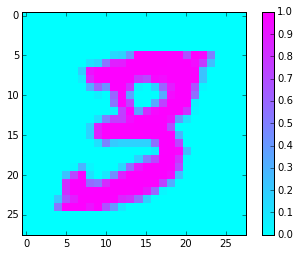

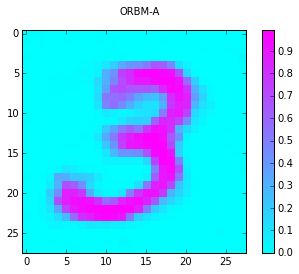

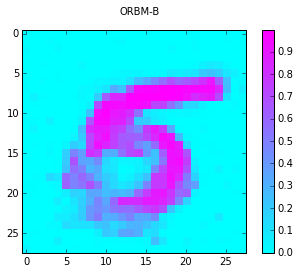

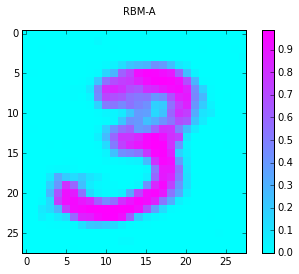

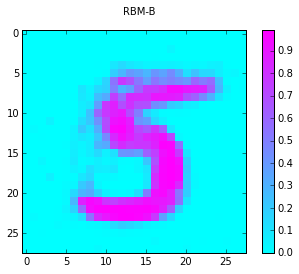

In [6]:
plot_recon_from_result(reconstructions_from_comp(mnist_data,(3,5), 1 , num_gibbs=10, sampler_class= ContinuousApproxSampler))

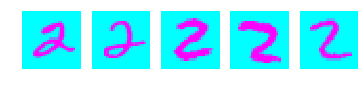

In [111]:
pp.images(mnist_data[2][1][:5])

In [38]:
pp.images(comp_of_size(mnist_data[4][1],mnist_data["bar"] ,10))

AttributeError: 'tuple' object has no attribute 'shape'

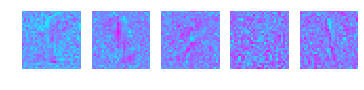

In [23]:
pp.images(mnist_data[1][0].weights.reshape(100,28,28)[:5])

In [13]:
# compose the current digit with all other digits
a =reconstructions_from_comp(mnist_data,(2,"bar"), 1 , num_gibbs=200, sampler_class= ContinuousApproxSampler)

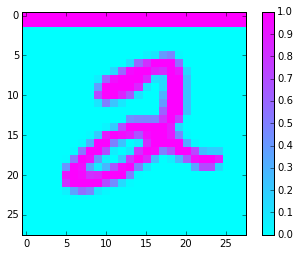

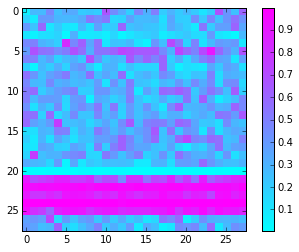

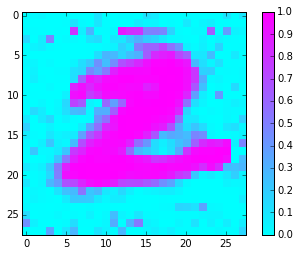

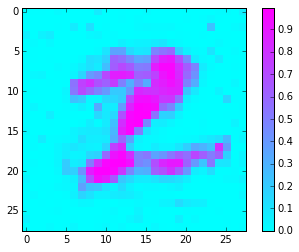

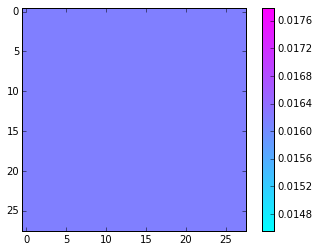

In [32]:
a.keys()
pp.image(a["DS_COMP"].reshape(28,28))
pp.image(a["RECON"][1].reshape(28,28))
pp.image(a["RECON"][0].reshape(28,28))
pp.image(a["VAN-RECON-A"].reshape(28,28))
pp.image(a["VAN-RECON-B"].reshape(28,28))

results = {}
for digit in range(1,9):
    if digit != 7 and digit != 9:
        for other_digit in range(1,9):
            if other_digit != 7 and other_digit != 9:
                results[(digit, other_digit)] = perform_for_digits(mnist_data,(digit,other_digit), 100 , num_gibbs=100, times=20)
            other_digit += 1
    digit += 1

with open("results.pickilo","wb") as f:
    pickle.dump(results, f)

In [7]:
# num_gibbs = 5
results = {}
# for digit in range(1,9):
#     if digit != 7 and digit != 9:
#         for other_digit in range(1,9):
#             if other_digit != 7 and other_digit != 9:
#                 results[(digit, other_digit)] = collect_gibbs_chain_data(mnist_data,(digit,other_digit), num_gibbs=num_gibbs)
#             other_digit += 1
#     digit += 1
results[(2, 3)] = collect_gibbs_chain_data(mnist_data,(2,3), num_gibbs=500) 

INFO:EVAL(2, 3):Created Progress logger for task - EVAL(2, 3)
INFO:MonitoredSampler:Created Progress logger for task - MonitoredSampler
INFO:MonitoredSampler:0.0% complete
INFO:MonitoredSampler:10.0% complete
INFO:MonitoredSampler:20.0% complete
INFO:MonitoredSampler:30.0% complete
INFO:MonitoredSampler:40.0% complete
INFO:MonitoredSampler:50.0% complete
INFO:MonitoredSampler:60.0% complete
INFO:MonitoredSampler:70.0% complete
INFO:MonitoredSampler:80.0% complete
INFO:MonitoredSampler:90.0% complete
INFO:EVAL(2, 3):0.0% complete
INFO:MonitoredSampler:Created Progress logger for task - MonitoredSampler
INFO:MonitoredSampler:0.0% complete
INFO:MonitoredSampler:10.0% complete
INFO:MonitoredSampler:20.0% complete
INFO:MonitoredSampler:30.0% complete
INFO:MonitoredSampler:40.0% complete
INFO:MonitoredSampler:50.0% complete
INFO:MonitoredSampler:60.0% complete
INFO:MonitoredSampler:70.0% complete
INFO:MonitoredSampler:80.0% complete
INFO:MonitoredSampler:90.0% complete
INFO:MonitoredSampler:

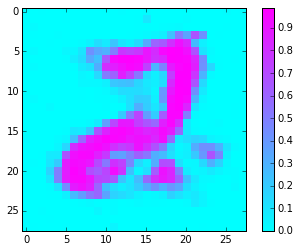

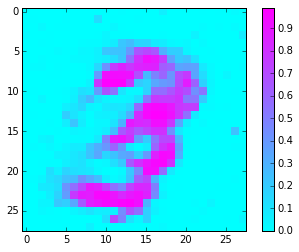

In [9]:
hidden_over_d = results[(2,3)][0]
visible_over_d = results[(2,3)][1]
gibbs = 2
pp.image(visible_over_d[0][gibbs][0].reshape(28,28))
pp.image(visible_over_d[0][gibbs][1].reshape(28,28))
data_item = 0
images_model_one = []
images_model_two = []
for gibbs in visible_over_d[data_item]:
    images_model_one.append(gibbs[0].reshape(28,28))
    images_model_two.append(gibbs[1].reshape(28,28))

In [10]:
for key in results:
    digit_combo_stats = results[key]
    for stats in digit_combo_stats[1]:
        reconstruction = stats[0].reshape(28,28) # GRAB FIRST OF TUP;E
        pp.image(reconstruction)

AttributeError: 'tuple' object has no attribute 'reshape'

In [11]:
import matplotlib.animation as animation

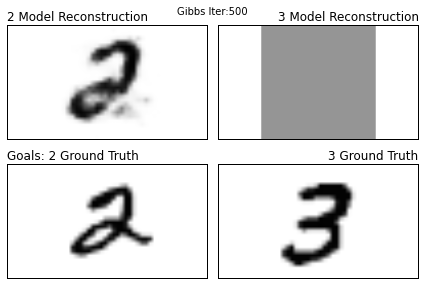

In [13]:




# images = results[(4,2)][1]
fig,((ax, ax2),( ax3, ax4)) = plt.subplots(2,2,sharex='col', sharey='row')
all_axes = [ax, ax2, ax3, ax4]

fig.suptitle("Gibbs Iter:1", fontsize=10)
im = ax.imshow(images_model_one[0], cmap=plt.get_cmap('Greys'))
im2 = ax2.imshow(images_model_two[0], cmap=plt.get_cmap('Greys'))
im3 = ax3.imshow(ds_twos[0],cmap=plt.cm.Greys)
im4 = ax4.imshow(ds_three[0],cmap=plt.cm.Greys)

for axes in all_axes:
    axes.get_xaxis().set_ticks([])
    axes.get_yaxis().set_ticks([])

# ax.imshow
ax.set_title("2 Model Reconstruction",loc="left")
ax2.set_title("3 Model Reconstruction", loc= 'right')
ax3.set_title("Goals: 2 Ground Truth", loc = "left")
ax4.set_title("3 Ground Truth", loc = 'right')


plt.tight_layout()
def updatefig(i):
    fig.suptitle("Gibbs Iter:{}".format(i+1), fontsize= 10)
    im.set_array(images_model_one[i])
    im2.set_array(images_model_two[i])
    return [im]

ani = animation.FuncAnimation(fig, updatefig,frames=range(len(images_model_one)), interval=20, blit=True)
# plt.show()

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Max Godfrey'), bitrate=1800)
ani.save('11test11.mp4', writer=writer)

In [38]:
len(images)

100

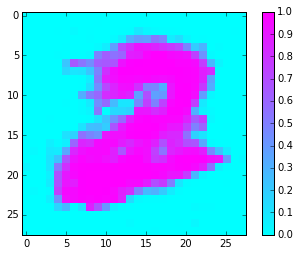

In [142]:
pp.image(images_model_one[0])

In [168]:
ds_twos[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.    

In [199]:
help(plt.subplots)


Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure with a set of subplots already made.
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Keyword arguments:
    
      *nrows* : int
        Number of rows of the subplot grid.  Defaults to 1.
    
      *ncols* : int
        Number of columns of the subplot grid.  Defaults to 1.
    
      *sharex* : string or bool
        If *True*, the X axis will be shared amongst all subplots.  If
        *True* and you have multiple rows, the x tick labels on all but
        the last row of plots will have visible set to *False*
        If a string must be one of "row", "col", "all", or "none".
        "all" has the same effect as *True*, "none" has the same effect
        as *False*.
        If "row", eac

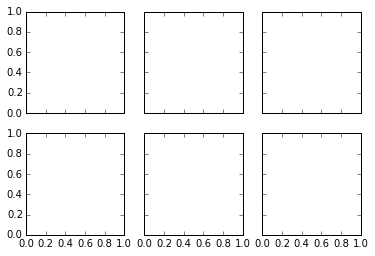

In [207]:
fig,yerp = plt.subplots(2,3,sharex='col', sharey='row', squeeze=True)

In [15]:
def no_ticks(x):
    x.get_xaxis().set_ticks([])
    x.get_yaxis().set_ticks([])
    return x

In [16]:
def make_me_a_movie_star(item, visible_over_d, hidden_over_d, filename):
    images_model_one,images_model_two = image_data_for_item(visible_over_d, item)
    h_a, h_b = image_data_for_hidden(hidden_over_d, item) 
    
    fig = plt.figure()
    ax1 = plt.subplot2grid((3,3), (0,1))
    ax2 = plt.subplot2grid((3,3), (0,0))
    ax3 = plt.subplot2grid((3,3), (0, 2))
    ax4 = plt.subplot2grid((3,3), (1, 0))
    ax5 = plt.subplot2grid((3,3), (1, 2))
    ax6 = plt.subplot2grid((3,3), (2, 0))
    ax7 = plt.subplot2grid((3,3), (2, 2))
    list(map(no_ticks, fig.get_axes()))
    fig.suptitle("Gibbs Iter:1", fontsize=10)
    ax1.set_title("Composite Input")
    ax2.set_title("Ground Truth 2")
    ax3.set_title("Ground Truth 3")
    ax4.set_title("ORBM Recon 2")
    ax5.set_title("ORBM Recon 3")
    
    ax6.set_title("Hidden 2")
    ax7.set_title("Hidden 3")

    ax1.imshow(comp_of_size(ds_twos,ds_three,500)[item].reshape(28,28), cmap=plt.cm.Greys)
    im1 = ax4.imshow(images_model_one[0], cmap=plt.get_cmap('Greys'), interpolation = 'nearest')
    im2 = ax5.imshow(images_model_two[0], cmap=plt.get_cmap('Greys'),  interpolation = 'nearest')
    im3 = ax6.imshow(h_a[0], cmap = plt.cm.Greys, interpolation = 'nearest')
    im4 = ax7.imshow(h_b[0], cmap = plt.cm.Greys, interpolation = 'nearest')
    
    ax2.imshow(ds_twos[item],cmap=plt.cm.Greys,  interpolation = 'nearest')
    ax3.imshow(ds_three[item],cmap=plt.cm.Greys,  interpolation = 'nearest')


    def updatefig(i):
        fig.suptitle("Gibbs Iter:{}".format(i+1), fontsize= 10)
        im1.set_array(images_model_one[i])
        im2.set_array(images_model_two[i])
        im3.set_array(h_a[i])
        im4.set_array(h_b[i])
        return [im1]

    ani = animation.FuncAnimation(fig, updatefig,frames=range(len(images_model_one)), interval=20, blit=True)
    # plt.show()

    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Max Godfrey'), bitrate=1800)
    ani.save(filename, writer=writer)
    

In [17]:
def image_data_for_item(visible_over_d,item):
    images_model_one = []
    images_model_two = []
    for gibbs in visible_over_d[item]:
        images_model_one.append(gibbs[0].reshape(28,28))
        images_model_two.append(gibbs[1].reshape(28,28))
    return images_model_one, images_model_two

def image_data_for_hidden(hidden_over_d, item):
    hid_a = []
    hid_b = []
    for gibbs in hidden_over_d[item]:
        hid_a.append(gibbs[0].reshape(10,10))
        hid_b.append(gibbs[1].reshape(10,10))
    return hid_a, hid_b

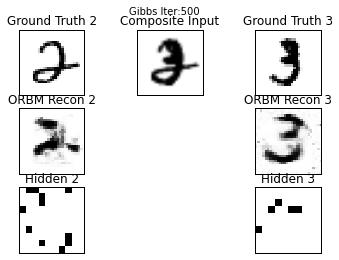

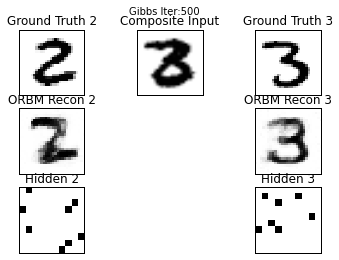

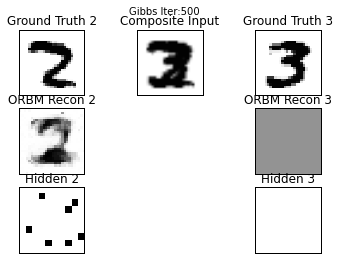

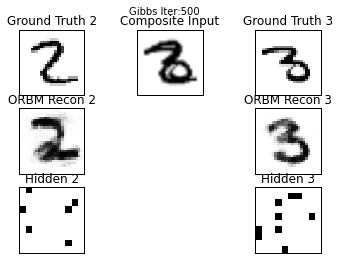

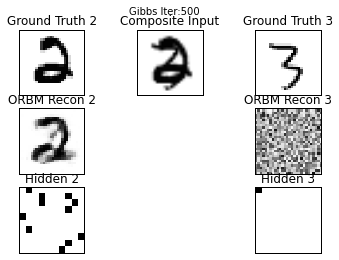

In [18]:
hidden_over_d = results[(2,3)][0]
visible_over_d = results[(2,3)][1]



make_me_a_movie_star(1, visible_over_d,hidden_over_d,"mixing1.mp4")
make_me_a_movie_star(2, visible_over_d,hidden_over_d,"mixing2.mp4")
make_me_a_movie_star(3, visible_over_d,hidden_over_d,"mixing3.mp4")
make_me_a_movie_star(4, visible_over_d,hidden_over_d,"mixing4.mp4")
make_me_a_movie_star(5, visible_over_d,hidden_over_d,"mixing5.mp4")

In [14]:
!say "done"

In [27]:
weights = mnist_data[2][0].weights.copy()

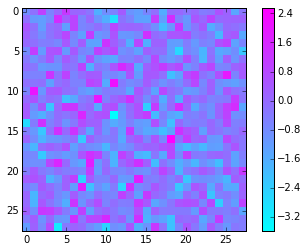

In [28]:
pp.image(weights.reshape(100, 28, 28)[0])

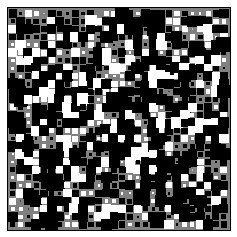

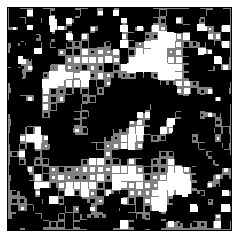

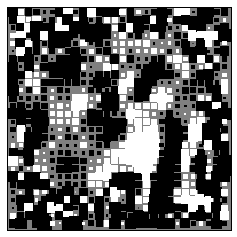

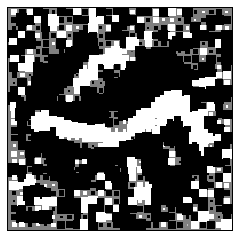

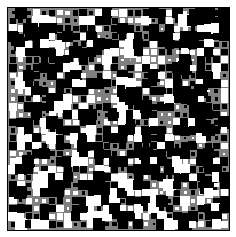

In [30]:
for i in range(5):
    pp.hinton(weights.reshape(100, 28, 28)[i])
    plt.show()